### Add feature engineering one piece at a time and monitor performance.  This notebook goes through all but the last model.

| model | agg. log loss  |  agg. F1 score |  comment
|-------|:--------------:|:--------------:|----------
|mod3_1 |  0.0573        |   0.982        | text features only, add bigrams
|mod3_1a|  0.0593        |   0.982        | text features only, add bigrams, add scaler
|mod3_2 |  0.305         |   0.900        | same, but reduce to 300 features using SelectKBest
|mod3_2a|  0.0798        |   0.976        | same, but reduce to 3000 features using SelectKBest
|mod3_2b|  0.0589        |   0.982        | same, but reduce to 15000 features using SelectKBest
|mod3_3 |  0.0580        |   0.982        | same, but reduce to 15000 features using SelectKBest

#### Best competition score was mod3_1; none of the feature selections helped, though some were close.



### Add the other feature engineering/modeling techniques starting with mod_1_1_1

We're starting here because this has better performance that all 5 models in the tutorial.  

Start with mod1_1_1
* mod1_1_1 - substitute zeros for numerical features (work-around for n_jobs bug), default CountVectorizer.

* __mod3_1 is best so far: log loss on training set: 0.0467, log loss on test set: 0.0573; Average F1 and accuracy all targets : 0.982.  Competition score: 0.6599.__


Add the following:
* text features
    * in count_vectorizer: ngram_range=(1, 2) - improves model performance significantly but doubles fitting time.  The feature set goes from 3.6k tokens to 31k features (tokens + bigrams).
    * SelectKBest(chi2, chi_k)
* scale with MaxAbsScaler
* reduce dimensions
    * selectKbest - 300 features
    * selectKbest - 1000 features
    * selectKbest - 15000 features
    * SelectFromModel(RandomForest) - - 15000 features
    
Summary: Reducing the features doesn't help.  The more features you keep, the better the classification.  It does seem that the real motivation for reducing size of the feature set is to limit the number of features to combine for feature interaction in the next step.  

* add feature interaction with sparse_interaction - see next notebook.

#### Imports/setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 60)

from timeit import default_timer as timer

In [2]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

import python.flat_to_labels as ftl

In [3]:
from python.dd_mmll import multi_multi_log_loss, BOX_PLOTS_COLUMN_INDICES
BPCI = BOX_PLOTS_COLUMN_INDICES

In [4]:
from python.multilabel import multilabel_train_test_split

In [5]:
# for the pipeline
from sklearn.pipeline import Pipeline
# for the selectors
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler
# for gluing preprocessed text and numbers together
from sklearn.pipeline import FeatureUnion
# for nans in the numeric data
from sklearn.preprocessing import Imputer

In [6]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# feature selection
from sklearn.feature_selection import SelectFromModel

#### Load the data

In [7]:
# Get data
df = pd.read_csv('data/TrainingData.csv', index_col=0)

In [8]:
# take a look
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


####  Encode the targets as categorical variables

In [9]:
### bind variable LABELS - these are actually the targets and we're going to one-hot encode them...
LABELS = ['Function',  'Use',  'Sharing',  'Reporting',  'Student_Type',  'Position_Type', 
          'Object_Type',  'Pre_K',  'Operating_Status']

### This turns out to be key.  Submission requires the dummy versions of these vars to be in this order.
LABELS.sort()

# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object


##### Let's save the unique labels for each output (category)

In [10]:
# build a dictionary
the_labels = {col : df[col].unique().tolist() for col in df[LABELS].columns}

In [11]:
the_labels['Use']

['Instruction',
 'NO_LABEL',
 'O&M',
 'Pupil Services & Enrichment',
 'ISPD',
 'Leadership',
 'Business Services',
 'Untracked Budget Set-Aside']

#### Show metrics for each target and average for all targets.

In [12]:
def report_f1(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = f1_score(true[:, target], pred[:, target], average='weighted')
        print('F1 score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average F1 score for all targets : {:.3f}'.format(np.mean(the_scores)))

def report_accuracy(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = accuracy_score(true[:, target], pred[:, target])
        print('Accuracy score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average accuracy score for all targets : {:.3f}'.format(np.mean(the_scores)))

#### Log loss

I want to see the aggregate log loss, but also need the values for each target. It works a bit differently for log_loss because log_loss uses the probability predictions and wants the true labels in binarized format.

In [13]:
# LABELS = ['Function', 'Object_Type','Operating_Status', 'Position_Type', 'Pre_K', 
#           'Reporting','Sharing', 'Student_Type','Use']
# BPCI is the slices that get the columns associated with LABELS, i.e.
#          [slice(0, 37, None), slice(37, 48, None), slice(48, 51, None), slice(51, 76, None), slice(76, 79, None), 
#           slice(79, 82, None), slice(82, 87, None), slice(87, 96, None), slice(96, 104, None)]

# grab the columns for each target - that's in BPCI indexed by position in LABELS
# normalize so probabilities sum to one (unless sum is zero, then we clip)

BCPI=BOX_PLOTS_COLUMN_INDICES

def norm_probs(probs, indices=BPCI, targets = LABELS):
    ''' input:  array n_samples, 104 ; output: array n_samples, 104 
         normalized within target columns such that for each target, the sum of probabilities for each row is 1'''
    # make a copy; don't want to smash the input
    lprobs = np.copy(probs)
    for i, targ in enumerate(targets):
        lprobs[:, indices[i]] /=  np.clip(np.sum(lprobs[:, indices[i]], axis=1, keepdims=True), 1e-15, np.inf)
    return lprobs

from sklearn.metrics import log_loss
def report_log_loss(true, pred):
    ''' Takes true in binarized format.  Both args are shape (n_samples, 104)'''
    the_scores = []
    # note: BPCI[idx] is the slice that gets the right columns for each target
    # first normalize probabilities within targets 
    normed_probas = norm_probs(pred)
    the_scores = []
    for idx, target in enumerate(LABELS):
        the_score = log_loss(true[:, BPCI[idx]], pred[:, BPCI[idx]])
        print('log loss for target {}: {:.3f}'.format(target, the_score))
        the_scores.append(the_score)
    print('Average log_loss for all targets : {:.3f}'.format(np.mean(the_scores))) 

In [14]:
NUMERIC_COLUMNS = ['FTE', 'Total']

In [15]:
# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

### Add text processing to the model

In [16]:
# define combine_text_columns()
def combine_text_columns(df, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text columns in each row of df to single string """
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(df.columns.tolist())
    text_data = df.drop(to_drop, axis=1)  
    # Replace nans with blanks
    text_data.fillna('', inplace=True)    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [17]:
# test it
combine_text_columns(df.sample(n=10))

325908    PURCHASED FOOD  SCHOOL NUTRITION SERVICE      ...
334752    SALARIES OF PART TIME EMPLOYEE TEACHER LEARNIN...
343638    SALARIES OF REGULAR EMPLOYEES  GENERAL FUND Nu...
444279    SUPPLIES  PRIMARY GRADES PROGRAM       INSTRUC...
66600     ALL OTHER SUPPLEMENTS            TEACHER, THIR...
84812     ADDITIONAL/EXTRA DUTY PAY/STIP  ARRA - STIMULU...
448545    Personal Services - Other Personnel   PRE-REFE...
320496    EMPLOYEE BENEFITS  GENERAL FUND Teacher, Eleme...
379967    EMPLOYEE BENEFITS  GENERAL FUND Teacher, Eleme...
131671    OTHER SUPPORT PERSONNEL          BUS DRIVER   ...
dtype: object

#### Add pipeline

The tutorial introduces a pipeline to consolidate preprocessing and modeling in a single classifier/estimator and to facilitate experimentation with both preprocessing and different models.

#### Build the pipeline

### The numeric data is not helpful.

Between mod1 and mod3 (mod2 only changes the classifier to RandomForest, leaving preprocessing alone) the changes are:

1. tokenize on alphanumeric (instead of default)
2. Add bigrams to CountVectorizer (previously was used with default settings).  This doubles the size of the wordvec space.
3. Dimension reduction with SelectKBest using chi-squared (300 features)

Some things to note about the default CountVectorizer:
1) All strings are downcased
2) The default setting selects tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator).  This means single letter or digit tokens are ignored.
3) If the vectorizer is used to transform another input (e.g. test), any tokens not in the original corpus are ignored.


#### One other way to work around bug exposed with CountVectorizer/OneVsRest/Logistic would be to replace all the numeric values with 0.  The classifiers  should ignore (and might work with n_jobs=-1).

Yes, this works well and uses all processors yielding the same results as the slower, 1-processor version above.  Fits in 464 sec instead of 827 sec.

##### Note: after some change in sklearn in anaconda update, n_jobs=-1 in OneVsRest causes hang.  Removed all parallelism in those calls.

In [18]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)
# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Use all 0s instead of noise: get_numeric_data
get_numeric_data_hack = FunctionTransformer(lambda x: np.zeros(x[NUMERIC_COLUMNS].shape, dtype=np.float), validate=False)

#### Build the pipeline

In [19]:
# Complete the pipeline: pl
mod_1_1_1 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer())]))
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = timer()
# Fit to the training data
mod_1_1_1.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 855.26 seconds


In [20]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod_1_1_1_yhat_train_probas = mod_1_1_1.predict_proba(X_train)
mod_1_1_1_yhat_test_probas = mod_1_1_1.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 16.32 seconds


In [21]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod_1_1_1_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod_1_1_1_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.0874
log loss on test set: 0.0940


In [22]:
type(y_test.values)

numpy.ndarray

In [23]:
y_test.values.shape,  mod_1_1_1_yhat_test_probas.shape

((80055, 104), (80055, 104))

In [24]:
BPCI[0]

range(0, 37)

In [25]:
report_log_loss(y_test.values, mod_1_1_1_yhat_test_probas)

log loss for target Function: 0.169
log loss for target Object_Type: 0.062
log loss for target Operating_Status: 0.050
log loss for target Position_Type: 0.071
log loss for target Pre_K: 0.033
log loss for target Reporting: 0.093
log loss for target Sharing: 0.134
log loss for target Student_Type: 0.093
log loss for target Use: 0.140
Average log_loss for all targets : 0.094


In [26]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod_1_1_1_yhat_test_probas))

F1 score for target Function: 0.955
F1 score for target Object_Type: 0.984
F1 score for target Operating_Status: 0.984
F1 score for target Position_Type: 0.982
F1 score for target Pre_K: 0.990
F1 score for target Reporting: 0.972
F1 score for target Sharing: 0.962
F1 score for target Student_Type: 0.973
F1 score for target Use: 0.961
Average F1 score for all targets : 0.974


In [27]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod_1_1_1_yhat_test_probas))

Accuracy score for target Function: 0.955
Accuracy score for target Object_Type: 0.984
Accuracy score for target Operating_Status: 0.985
Accuracy score for target Position_Type: 0.983
Accuracy score for target Pre_K: 0.990
Accuracy score for target Reporting: 0.973
Accuracy score for target Sharing: 0.963
Accuracy score for target Student_Type: 0.973
Accuracy score for target Use: 0.961
Average accuracy score for all targets : 0.974


#### =============================== End of mod_1_1_1 ============================================

---

__================================ Begin Mod3_1 *(add bigrams)* ==================================__

In [28]:
# Complete the pipeline: pl
mod3_1 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2)))]))
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = timer()
# Fit to the training data
mod3_1.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 1549.78 seconds


In [29]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod3_1_yhat_train_probas = mod3_1.predict_proba(X_train)
mod3_1_yhat_test_probas = mod3_1.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 26.80 seconds


In [30]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_1_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod3_1_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.0467
log loss on test set: 0.0573


In [31]:
report_log_loss(y_test.values, mod3_1_yhat_test_probas)

log loss for target Function: 0.114
log loss for target Object_Type: 0.041
log loss for target Operating_Status: 0.038
log loss for target Position_Type: 0.045
log loss for target Pre_K: 0.026
log loss for target Reporting: 0.051
log loss for target Sharing: 0.069
log loss for target Student_Type: 0.055
log loss for target Use: 0.077
Average log_loss for all targets : 0.057


In [32]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_1_yhat_test_probas))

F1 score for target Function: 0.965
F1 score for target Object_Type: 0.987
F1 score for target Operating_Status: 0.987
F1 score for target Position_Type: 0.987
F1 score for target Pre_K: 0.991
F1 score for target Reporting: 0.984
F1 score for target Sharing: 0.979
F1 score for target Student_Type: 0.981
F1 score for target Use: 0.975
Average F1 score for all targets : 0.982


In [33]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_1_yhat_test_probas))

Accuracy score for target Function: 0.965
Accuracy score for target Object_Type: 0.987
Accuracy score for target Operating_Status: 0.987
Accuracy score for target Position_Type: 0.987
Accuracy score for target Pre_K: 0.991
Accuracy score for target Reporting: 0.984
Accuracy score for target Sharing: 0.979
Accuracy score for target Student_Type: 0.981
Accuracy score for target Use: 0.975
Average accuracy score for all targets : 0.982


#### Submit this because it's better...

In [34]:
# Load the holdout data: holdout
### Over here the file is TestData.csv
holdout = pd.read_csv('data/TestData.csv', index_col=0)

start = timer()
# Generate predictions: predictions
mod3_1_predictions = mod3_1.predict_proba(holdout)
end = timer()
print('predict time: {} seconds'.format(end - start))

pred_mod3_1 = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, 
                             index=holdout.index,
                             data=mod3_1_predictions)

pred_mod3_1.to_csv('pred_mod3_1.csv')

C:\Users\saus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


predict time: 3.2710341340325613 seconds


### Top 10 finish!! 0.6599 on holdout set at Drivendata (previous best 0.6827).

__============================= End Mod3_1 *(add bigrams)* ==================__

***

### Add the MaxAbsScaler

Speeds things up a small amount but also degrades quality slightly.

__===================== Begin Mod3_1a *(add bigrams, add MaxAbs scaler)* ==================__

In [35]:
# Complete the pipeline: pl
mod3_1a = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2)))]))
             ])),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = timer()
# Fit to the training data
mod3_1a.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 1139.97 seconds


In [36]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod3_1a_yhat_train_probas = mod3_1a.predict_proba(X_train)
mod3_1a_yhat_test_probas = mod3_1a.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 28.71 seconds


In [37]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_1a_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod3_1a_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.0492
log loss on test set: 0.0593


In [38]:
report_log_loss(y_test.values, mod3_1a_yhat_test_probas)

log loss for target Function: 0.119
log loss for target Object_Type: 0.044
log loss for target Operating_Status: 0.039
log loss for target Position_Type: 0.047
log loss for target Pre_K: 0.026
log loss for target Reporting: 0.052
log loss for target Sharing: 0.070
log loss for target Student_Type: 0.056
log loss for target Use: 0.080
Average log_loss for all targets : 0.059


In [39]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_1a_yhat_test_probas))

F1 score for target Function: 0.964
F1 score for target Object_Type: 0.987
F1 score for target Operating_Status: 0.987
F1 score for target Position_Type: 0.987
F1 score for target Pre_K: 0.991
F1 score for target Reporting: 0.984
F1 score for target Sharing: 0.979
F1 score for target Student_Type: 0.981
F1 score for target Use: 0.975
Average F1 score for all targets : 0.982


In [40]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_1a_yhat_test_probas))

Accuracy score for target Function: 0.965
Accuracy score for target Object_Type: 0.987
Accuracy score for target Operating_Status: 0.987
Accuracy score for target Position_Type: 0.987
Accuracy score for target Pre_K: 0.991
Accuracy score for target Reporting: 0.984
Accuracy score for target Sharing: 0.979
Accuracy score for target Student_Type: 0.981
Accuracy score for target Use: 0.975
Average accuracy score for all targets : 0.982


#### Does not score as well on DD site, but it fits faster.

In [41]:
# Load the holdout data: holdout
### Over here the file is TestData.csv
holdout = pd.read_csv('data/TestData.csv', index_col=0)

start = timer()
# Generate predictions: predictions
mod3_1a_predictions = mod3_1a.predict_proba(holdout)
end = timer()
print('predict time: {} seconds'.format(end - start))

pred_mod3_1a = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, 
                             index=holdout.index,
                             data=mod3_1a_predictions)

pred_mod3_1a.to_csv('pred_mod3_1a.csv')

C:\Users\saus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


predict time: 2.866064067691241 seconds


__============================= End mod3_1a *(add bigrams/MaxAbsScaler)* ==================__

---

__===================== Begin Mod3_2 *(reduce features with SelectKBest)* ==================__

### Now reduce features with SelectKBest, keeping 300 best features (chi$^2$)

Twice as fast; much worse predictions.

In [42]:
# add feature selection

from sklearn.feature_selection import chi2, SelectKBest

chi_k = 300

mod3_2 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2))),
                                            ('reduce', SelectKBest(chi2, chi_k))  ]))
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = timer()
# Fit to the training data
mod3_2.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 900.45 seconds


In [43]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod3_2_yhat_train_probas = mod3_2.predict_proba(X_train)
mod3_2_yhat_test_probas = mod3_2.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 22.84 seconds


In [44]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_2_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod3_2_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.3026
log loss on training set: 0.3050


In [45]:
report_log_loss(y_test.values, mod3_2_yhat_test_probas)

log loss for target Function: 0.523
log loss for target Object_Type: 0.298
log loss for target Operating_Status: 0.136
log loss for target Position_Type: 0.316
log loss for target Pre_K: 0.097
log loss for target Reporting: 0.291
log loss for target Sharing: 0.373
log loss for target Student_Type: 0.313
log loss for target Use: 0.397
Average log_loss for all targets : 0.305


In [46]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_2_yhat_test_probas))

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 score for target Function: 0.845
F1 score for target Object_Type: 0.909
F1 score for target Operating_Status: 0.952
F1 score for target Position_Type: 0.905
F1 score for target Pre_K: 0.965
F1 score for target Reporting: 0.895
F1 score for target Sharing: 0.872
F1 score for target Student_Type: 0.897
F1 score for target Use: 0.861
Average F1 score for all targets : 0.900


In [47]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_2_yhat_test_probas))

Accuracy score for target Function: 0.852
Accuracy score for target Object_Type: 0.911
Accuracy score for target Operating_Status: 0.954
Accuracy score for target Position_Type: 0.907
Accuracy score for target Pre_K: 0.966
Accuracy score for target Reporting: 0.897
Accuracy score for target Sharing: 0.877
Accuracy score for target Student_Type: 0.899
Accuracy score for target Use: 0.866
Average accuracy score for all targets : 0.903


### Results are much worse with this feature selection.   The speed up is not that impressive considering the fit time without SelectKFeatures was 800 sec. and with this scheme we're at 460 sec.

It could be because:
1. 300 is too few features
2. these are the wrong 300 to select.

We had something like 3k tokens in the fitted CountVectorizer.  Adding bigrams that takes us to 6k.

__===================== End Mod3_2 *(reduce features with SelectKBest)* ==================__

#### ===================== Begin Mod3_2a (reduce features with SelectKBest, 3000 best) ==================

In [48]:
# add feature selection

from sklearn.feature_selection import chi2, SelectKBest

chi_k = 3000

mod3_2a = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2))),
                                            ('reduce', SelectKBest(chi2, chi_k))  ]))
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = timer()
# Fit to the training data
mod3_2a.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 1269.22 seconds


In [49]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod3_2a_yhat_train_probas = mod3_2a.predict_proba(X_train)
mod3_2a_yhat_test_probas = mod3_2a.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 24.82 seconds


In [50]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_2a_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod3_2a_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.0738
log loss on training set: 0.0798


In [51]:
report_log_loss(y_test.values, mod3_2a_yhat_test_probas)

log loss for target Function: 0.150
log loss for target Object_Type: 0.056
log loss for target Operating_Status: 0.049
log loss for target Position_Type: 0.067
log loss for target Pre_K: 0.034
log loss for target Reporting: 0.070
log loss for target Sharing: 0.101
log loss for target Student_Type: 0.077
log loss for target Use: 0.114
Average log_loss for all targets : 0.080


In [52]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_2a_yhat_test_probas))

F1 score for target Function: 0.956
F1 score for target Object_Type: 0.983
F1 score for target Operating_Status: 0.984
F1 score for target Position_Type: 0.981
F1 score for target Pre_K: 0.989
F1 score for target Reporting: 0.979
F1 score for target Sharing: 0.970
F1 score for target Student_Type: 0.975
F1 score for target Use: 0.965
Average F1 score for all targets : 0.976


In [53]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_2a_yhat_test_probas))

Accuracy score for target Function: 0.956
Accuracy score for target Object_Type: 0.983
Accuracy score for target Operating_Status: 0.984
Accuracy score for target Position_Type: 0.981
Accuracy score for target Pre_K: 0.989
Accuracy score for target Reporting: 0.979
Accuracy score for target Sharing: 0.970
Accuracy score for target Student_Type: 0.975
Accuracy score for target Use: 0.965
Average accuracy score for all targets : 0.976


### Results for 3k features are better than 300, but less good than using all.   Slight speed up.

This might be okay for doing sparse interactions.  3000 * 3000 = 9M.  Don't know just how sparse everything will be.  Might run overnight.

#### ===================== End Mod3_2a (reduce features with SelectKBest, 3000 best) ==================

#### ===================== Begin Mod3_2b (reduce features with SelectKBest, 15000 best) ==================

In [54]:
# add feature selection

from sklearn.feature_selection import chi2, SelectKBest

chi_k = 15000

mod3_2b = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2))),
                                            ('reduce', SelectKBest(chi2, chi_k))  ]))
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = timer()
# Fit to the training data
mod3_2b.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 1475.92 seconds


In [55]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod3_2b_yhat_train_probas = mod3_2b.predict_proba(X_train)
mod3_2b_yhat_test_probas = mod3_2b.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 24.46 seconds


In [56]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_2b_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_2b_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.0500
log loss on training set: 0.0589


In [57]:
report_log_loss(y_test.values, mod3_2b_yhat_test_probas)

log loss for target Function: 0.117
log loss for target Object_Type: 0.042
log loss for target Operating_Status: 0.039
log loss for target Position_Type: 0.046
log loss for target Pre_K: 0.027
log loss for target Reporting: 0.052
log loss for target Sharing: 0.071
log loss for target Student_Type: 0.056
log loss for target Use: 0.080
Average log_loss for all targets : 0.059


In [58]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_2b_yhat_test_probas))

F1 score for target Function: 0.964
F1 score for target Object_Type: 0.987
F1 score for target Operating_Status: 0.986
F1 score for target Position_Type: 0.987
F1 score for target Pre_K: 0.991
F1 score for target Reporting: 0.984
F1 score for target Sharing: 0.979
F1 score for target Student_Type: 0.981
F1 score for target Use: 0.975
Average F1 score for all targets : 0.982


In [59]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_2b_yhat_test_probas))

Accuracy score for target Function: 0.965
Accuracy score for target Object_Type: 0.987
Accuracy score for target Operating_Status: 0.987
Accuracy score for target Position_Type: 0.987
Accuracy score for target Pre_K: 0.991
Accuracy score for target Reporting: 0.984
Accuracy score for target Sharing: 0.979
Accuracy score for target Student_Type: 0.981
Accuracy score for target Use: 0.975
Average accuracy score for all targets : 0.982


__===================== End Mod3_3 *(reduce features with SelectFromModel)* ==================__

## Interlude: What about the feature selection?  

#### I want to look at the features to see what they are.  But I need to do all the preprocessing first.

In [60]:
# We start with X_train; 16 column dataframe
type(X_train), X_train.shape

(pandas.core.frame.DataFrame, (320222, 16))

In [61]:
# then we combine all the columns with function xformer get_text_data
orig_texts = combine_text_columns(X_train)

In [62]:
X_train.iloc[0, :]

Object_Description                        NaN
Text_2                                    NaN
SubFund_Description                       NaN
Job_Title_Description     Teacher-Elementary 
Text_3                                    NaN
Text_4                                    NaN
Sub_Object_Description                    NaN
Location_Description                      NaN
FTE                                         1
Function_Description                      NaN
Facility_or_Department                    NaN
Position_Extra                  KINDERGARTEN 
Total                                 50471.8
Program_Description              KINDERGARTEN
Fund_Description                 General Fund
Text_1                                    NaN
Name: 134338, dtype: object

In [63]:
# pandas series
type(orig_texts), orig_texts.shape

(pandas.core.series.Series, (320222,))

In [64]:
orig_texts.values[0]

'   Teacher-Elementary        KINDERGARTEN  KINDERGARTEN General Fund '

In [65]:
v1 = CountVectorizer(ngram_range=(1,1))

In [66]:
%%time
features = v1.fit_transform(orig_texts)

Wall time: 5.5 s


In [67]:
type(features), features.shape

(scipy.sparse.csr.csr_matrix, (320222, 3619))

In [95]:
print(v1.get_feature_names()[1500:1600])

['hardware', 'harvard', 'hat', 'hate', 'hats', 'hay', 'hazardous', 'hazmat', 'hb', 'hbsc', 'hd', 'hdc', 'he', 'hea', 'head', 'headstar', 'headstart', 'healt', 'health', 'healthier', 'healthiest', 'healthly', 'healthy', 'healty', 'hear', 'hearing', 'hearings', 'heart', 'heating', 'heavy', 'heights', 'held', 'help', 'helper', 'helpline', 'here', 'hh', 'hhs', 'hi', 'hidden', 'high', 'higher', 'highly', 'highway', 'hire', 'hirin', 'hist', 'history', 'hiv', 'hlth', 'hmn', 'hndcpd', 'hoa', 'hof', 'holding', 'holdings', 'holiday', 'home', 'homebased', 'homebound', 'homegrown', 'homeless', 'homes', 'homework', 'horticulture', 'hospital', 'hospitality', 'hospitals', 'host', 'hosts', 'hour', 'hourly', 'hous', 'house', 'housing', 'hqt', 'hr', 'hris', 'hrly', 'hrs', 'hs', 'hsbc', 'hst', 'hstw', 'hub', 'hubs', 'human', 'humanities', 'humanware', 'hurricane', 'hvac', 'hvy', 'hydronic', 'hygiene', 'ia', 'iaf', 'ib', 'ic', 'id', 'idea']


In [69]:
v2 = CountVectorizer(ngram_range=(1,2))

In [70]:
%%time
features2grams = v2.fit_transform(orig_texts)

Wall time: 10.4 s


#### Interesting: Adding bigrams takes us from 3.6k tokens to 31k features (tokens + bigrams)

In [71]:
type(features2grams), features2grams.shape

(scipy.sparse.csr.csr_matrix, (320222, 31010))

In [96]:
print(v2.get_feature_names()[15000:15100])

['lep clerical', 'lep computer', 'lep counselor', 'lep critical', 'lep curriculum', 'lep custodian', 'lep extended', 'lep medicare', 'lep miscellaneous', 'lep ninth', 'lep overtime', 'lep regular', 'lep skills', 'lep summer', 'lep teach', 'lep teacher', 'lep temporary', 'lep to', 'lep travel', 'less', 'less than', 'let', 'let me', 'level', 'level chair', 'level dept', 'levy', 'levy admin', 'levy administrator', 'levy asst', 'levy blank', 'levy bookkeeper', 'levy bus', 'levy coordinator', 'levy counter', 'levy credit', 'levy data', 'levy deputy', 'levy dir', 'levy early', 'levy ela', 'levy elementary', 'levy exec', 'levy extended', 'levy facilitator', 'levy general', 'levy health', 'levy helper', 'levy itemge', 'levy itinerant', 'levy library', 'levy maintenance', 'levy manager', 'levy military', 'levy nurse', 'levy office', 'levy opp', 'levy override', 'levy passroom', 'levy pest', 'levy prevent', 'levy principal', 'levy program', 'levy project', 'levy protech', 'levy psychologist', 'l

In [73]:
est = RandomForestClassifier(n_jobs=-1).fit(features2grams, y_train)

In [74]:
est.feature_importances_

array([4.49656645e-05, 0.00000000e+00, 5.14667071e-09, ...,
       5.61730428e-08, 6.42651010e-09, 0.00000000e+00])

In [75]:
f_is_ = est.feature_importances_

In [76]:
f_is_.shape

(31010,)

In [77]:
np.sum(f_is_)

0.9999999999999999

In [78]:
np.mean(f_is_), np.median(f_is_)

(3.224766204450177e-05, 6.45473520818476e-07)

In [79]:
np.sum(f_is_[f_is_ < 0.2 * np.median(f_is_)])

0.00013773350387231845

C:\Users\saus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


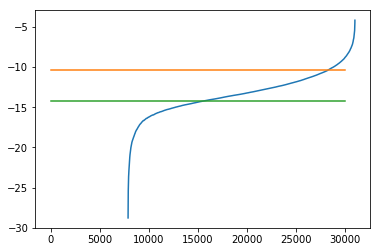

In [80]:
plt.plot(np.log(np.sort(f_is_)))
plt.plot(np.array([0, 30000]), np.ones(2) * np.log(np.mean(f_is_)))
plt.plot(np.array([0, 30000]), np.ones(2) * np.log(np.median(f_is_)))

---

__===================== Begin Mod3_3 *(reduce features with SelectFromModel)* ==================__

#### Now put the selector in the pipeline....

This is going to be slow because it has to fit two models, the RF for feature importance and then the OneVsRest(Logistic..()).  

I think it's going to end up using 15k features by kicking out everything of less than median importance).  That's still a __lot__ of features.  But I did use them all previously (800 sec, I think).

It's very nearly as good but ends up taking 50% longer than using the whole feature set.

In [81]:
mod3_3 = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2))),
                                            ('reduce', SelectFromModel(RandomForestClassifier(n_jobs=-1), 
                                                                       threshold='median')) ] ) )
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = timer()
# Fit to the training data
mod3_3.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 2124.54 seconds


In [82]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod3_3_yhat_train_probas = mod3_3.predict_proba(X_train)
mod3_3_yhat_test_probas = mod3_3.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 27.24 seconds


In [83]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_3_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod3_3_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.0481
log loss on test set: 0.0580


In [84]:
report_log_loss(y_test.values, mod3_3_yhat_test_probas)

log loss for target Function: 0.116
log loss for target Object_Type: 0.041
log loss for target Operating_Status: 0.039
log loss for target Position_Type: 0.045
log loss for target Pre_K: 0.026
log loss for target Reporting: 0.051
log loss for target Sharing: 0.070
log loss for target Student_Type: 0.055
log loss for target Use: 0.079
Average log_loss for all targets : 0.058


In [85]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_3_yhat_test_probas))

F1 score for target Function: 0.965
F1 score for target Object_Type: 0.987
F1 score for target Operating_Status: 0.987
F1 score for target Position_Type: 0.987
F1 score for target Pre_K: 0.991
F1 score for target Reporting: 0.984
F1 score for target Sharing: 0.979
F1 score for target Student_Type: 0.981
F1 score for target Use: 0.975
Average F1 score for all targets : 0.982


In [86]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_3_yhat_test_probas))

Accuracy score for target Function: 0.965
Accuracy score for target Object_Type: 0.987
Accuracy score for target Operating_Status: 0.987
Accuracy score for target Position_Type: 0.987
Accuracy score for target Pre_K: 0.991
Accuracy score for target Reporting: 0.984
Accuracy score for target Sharing: 0.979
Accuracy score for target Student_Type: 0.981
Accuracy score for target Use: 0.975
Average accuracy score for all targets : 0.982


__===================== End Mod3_3 *(reduce features with SelectFromModel)*  ==================__

## Interlude: model persistence - mod3_3 won't pickle

In [87]:
!mkdir model_store

A subdirectory or file model_store already exists.


In [88]:
### PicklingError: Can't pickle <function <lambda> at 0x000002236E61DEA0>: attribute lookup <lambda> on __main__ failed
#import pickle
#saved_model = pickle.dumps(mod3_3

In [89]:
### This fails with a pickling error maybe have to import pickle first
# from sklearn.externals import joblib
# joblib.dump(mod3_3,'./model_store/fitted_mod3_3.pkl') 

### This isn't the way to do this.  It ends up almost as good but much, much slower.

#### just for yucks let's use L1 penalty in the LogReg.  It may null out different features for different labels.   Don't think it will take too long to run.  C=0.8 is not too much regularization.    We were at 800 sec before.  If this works like I think, it should go a bit faster, but hopefully won't add much bias (we're not overfitted).

Completely wrong.  Took 1900 seconds (more than double).  Maybe it has to calculate the regularization and multiply it and that's got to be at least twice the math work)...

### Run this again when time allows with C=0.5

In [90]:
# # Complete the pipeline: pl
# mod3_1L1 = Pipeline([
#         ('union', FeatureUnion(
#             transformer_list = [
#                 ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
#                                                ('imputer', Imputer())])),
#                 ('text_features', Pipeline([('selector', get_text_data),
#                                             ('vectorizer', CountVectorizer(ngram_range=(1,2)))]))
#              ])),
#         ('clf', OneVsRestClassifier(LogisticRegression(penalty='l1', C=0.8), n_jobs=-1))
#     ])

# start = timer()
# # Fit to the training data
# mod3_1L1.fit(X_train, y_train)
# end = timer()
# print('fit time: {:0.2f} seconds'.format(end - start))

# fit time: 1908.42 seconds

In [91]:
### For log loss we need the probabilities, not the predicted labels
# start = timer()
# mod3_1L1_yhat_train_probas = mod3_1L1.predict_proba(X_train)
# mod3_1L1_yhat_test_probas = mod3_1L1.predict_proba(X_test)
# end = timer()
# print('Predict.proba time: {:0.2f} seconds'.format(end - start))

In [92]:
# print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_1L1_yhat_train_probas, 
#                                                                       y_train.values, BOX_PLOTS_COLUMN_INDICES)))
# print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod3_1L1_yhat_test_probas, 
#                                                                       y_test.values, BOX_PLOTS_COLUMN_INDICES)))
# log loss on training set: 0.0511
# log loss on training set: 0.0588

In [93]:
# report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_1L1_yhat_test_probas))
# F1 score for target Function: 0.964
# F1 score for target Object_Type: 0.987
# F1 score for target Operating_Status: 0.987
# F1 score for target Position_Type: 0.987
# F1 score for target Pre_K: 0.991
# F1 score for target Reporting: 0.984
# F1 score for target Sharing: 0.979
# F1 score for target Student_Type: 0.981
# F1 score for target Use: 0.975
# Average F1 score for all targets : 0.982

In [94]:
# report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod3_1L1_yhat_test_probas))
# Accuracy score for target Function: 0.965
# Accuracy score for target Object_Type: 0.987
# Accuracy score for target Operating_Status: 0.987
# Accuracy score for target Position_Type: 0.987
# Accuracy score for target Pre_K: 0.991
# Accuracy score for target Reporting: 0.984
# Accuracy score for target Sharing: 0.979
# Accuracy score for target Student_Type: 0.981
# Accuracy score for target Use: 0.975
# Average accuracy score for all targets : 0.982
